In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
data_path = 'Bike-Sharing-Dataset/hour.csv'

rides = pd.read_csv(data_path)

In [13]:
rides.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,...,hr_21,hr_22,hr_23,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,1,2011-01-01,1,0,1,0,0,6,0,1,...,0,0,0,0,0,0,0,0,0,1
1,2,2011-01-01,1,0,1,1,0,6,0,1,...,0,0,0,0,0,0,0,0,0,1
2,3,2011-01-01,1,0,1,2,0,6,0,1,...,0,0,0,0,0,0,0,0,0,1
3,4,2011-01-01,1,0,1,3,0,6,0,1,...,0,0,0,0,0,0,0,0,0,1
4,5,2011-01-01,1,0,1,4,0,6,0,1,...,0,0,0,0,0,0,0,0,0,1


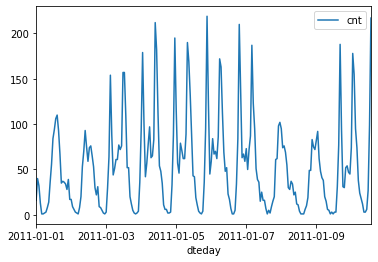

In [4]:
rides[:24*10].plot(x='dteday', y='cnt')

In [5]:
# 将日期季节等时间特征二值化（因为分类数据作数学运算无意义）
dummy_fields = ['season', 'weathersit', 'mnth', 'hr', 'weekday']
for each in dummy_fields:
    dummies = pd.get_dummies(rides[each], prefix=each, drop_first=False)
    rides = pd.concat([rides, dummies], axis=1)

#删除无用数据
fields_to_drop = ['instant', 'dteday', 'season', 'weathersit', 
                  'weekday', 'atemp', 'mnth', 'workingday', 'hr']
data = rides.drop(fields_to_drop, axis=1)
data.head()

,yr,holiday,temp,hum,windspeed,casual,registered,cnt,season_1,season_2,...,hr_21,hr_22,hr_23,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,0,0,0.24,0.81,0.0,3,13,16,1,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0.22,0.80,0.0,8,32,40,1,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0.22,0.80,0.0,5,27,32,1,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0.24,0.75,0.0,3,10,13,1,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0.24,0.75,0.0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,1


In [14]:
# 标准化
quant_features = ['casual', 'registered', 'cnt', 'temp', 'hum', 'windspeed']
# 将转换的值存储下来
scaled_features = {}
for each in quant_features:
    mean, std = data[each].mean(), data[each].std()
    scaled_features[each] = [mean, std]
    data.loc[:, each] = (data[each] - mean)/std

In [16]:
# 测试集为第21个月之后的数据
test_data = data[-21*24:]

# 从原始数据中删除测试集
data = data[:-21*24]

# 分离特征与标签
target_fields = ['cnt', 'casual', 'registered']
features, targets = data.drop(target_fields, axis=1), data[target_fields]
test_features, test_targets = test_data.drop(target_fields, axis=1), test_data[target_fields]

In [25]:
test_targets

,cnt,casual,registered
16875,-0.349876,-0.500481,-0.256260
16876,-0.581424,-0.561326,-0.513929
16877,-0.873616,-0.683018,-0.824452
16878,-1.000416,-0.703300,-0.969804
16879,-1.039008,-0.723582,-1.009445
...,...,...,...
17374,-0.388467,-0.500481,-0.302509
17375,-0.553859,-0.561326,-0.480894
17376,-0.548346,-0.581608,-0.467681
17377,-0.708224,-0.459917,-0.698922


In [17]:
#划分训练集与验证集
train_features, train_targets = features[:-60*24], targets[:-60*24]
val_features, val_targets = features[-60*24:], targets[-60*24:]

In [27]:
class NeuralNetwork(object):
    #生成一个双层网络模型
    def __init__(self, input_nodes, hidden_nodes, output_nodes, learning_rate):
        '''定义网络结构input_nodes--输入层节点数
                     hidden_nodes--中间层节点数
                     output_nodes--输出层节点数
                     learning_rate--学习率'''
        self.input_nodes = input_nodes
        self.hidden_nodes = hidden_nodes
        self.output_nodes = output_nodes

        # 生成结构是(input_nodes,hidden_nodes)的初始化权重
        self.weights_input_to_hidden = np.random.normal(0.0, self.input_nodes**-0.5, 
                                       (self.input_nodes, self.hidden_nodes))
        
        #生成结构是(hidden_nodes, output_nodes)的初始化权重
        self.weights_hidden_to_output = np.random.normal(0.0, self.hidden_nodes**-0.5, 
                                       (self.hidden_nodes, self.output_nodes))
        self.lr = learning_rate
        
        #定义sigmod激活函数
        self.activation_function = lambda x : 1/(1+np.exp(-x))
    
    def train(self, features, targets):
        '''训练数据集，实现正向和反向传播
            features: 数据
            targets: 标签'''
        n_records = features.shape[0]
        #初始化b值
        delta_weights_i_h = np.zeros(self.weights_input_to_hidden.shape)
        delta_weights_h_o = np.zeros(self.weights_hidden_to_output.shape)
        for X, y in zip(features, targets):
            #正向传播
            hidden_inputs = np.dot(X,self.weights_input_to_hidden)#隐藏层输入
            hidden_outputs = self.activation_function(hidden_inputs)#隐藏层输出
            
            final_inputs = np.dot(hidden_outputs, self.weights_hidden_to_output) # 输出层输入
            final_outputs = final_inputs # 输出层输出
            
            #计算误差
            error = y - final_outputs # Output layer error is the difference between desired target and actual output.
 
            # 输出层梯度
            output_error_term = error
            
            # 隐藏层-输出层梯度
            hidden_error = np.dot(self.weights_hidden_to_output,output_error_term[:,None])
            delta_weights_h_o += self.lr * hidden_outputs[:,None]*output_error_term
            # 输入层-隐藏层梯度
            hidden_error_term = (hidden_outputs * (1 - hidden_outputs))[:,None] * hidden_error
            delta_weights_i_h +=self.lr * np.dot(X[:,None],hidden_error_term.reshape(1,-1))
            
        # 根据梯度更新权重
        self.weights_hidden_to_output += delta_weights_h_o/n_records 
        self.weights_input_to_hidden += delta_weights_i_h/n_records 
 
    def run(self, features):
        '''输出当前状态模型的正向传播结果 '''
        # 输入层-输出层
        hidden_inputs = np.dot(features,self.weights_input_to_hidden)
        
        #激活函数
        hidden_outputs = self.activation_function(hidden_inputs)
        
        # 隐藏层-输出层
        final_inputs = np.dot(hidden_outputs,self.weights_hidden_to_output)
        final_outputs = final_inputs 

        return final_outputs

In [29]:
def MSE(y, Y):
    '''计算MSE平均平方误差'''
    return np.mean((y-Y)**2)

In [34]:
train_features.iloc[np.random.choice(train_features.index, size=128)]

,yr,holiday,temp,hum,windspeed,season_1,season_2,season_3,season_4,weathersit_1,...,hr_21,hr_22,hr_23,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
3847,0,0,0.223378,-0.348463,1.130474,0,1,0,0,1,...,0,0,0,0,0,1,0,0,0,0
5470,0,0,1.262036,-0.037469,0.276298,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,1
9960,1,0,-0.815280,-1.074115,1.374057,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
3774,0,0,0.950439,0.843681,-0.821460,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,1
4691,0,0,1.573634,0.014364,-0.456086,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14663,1,0,0.846573,1.621165,0.276298,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
10412,1,0,0.327244,-1.022283,-0.211685,1,0,0,0,1,...,0,0,1,0,0,0,1,0,0,0
6332,0,0,0.742707,1.362004,0.031898,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
14957,1,0,0.431110,-0.503960,-0.821460,0,0,1,0,1,...,0,0,0,0,0,0,0,1,0,0


In [49]:
import sys

#超参数
iterations = 5000
learning_rate = 0.5
hidden_nodes = 10
output_nodes = 1

input_nodes = train_features.shape[1]
network = NeuralNetwork(input_nodes, hidden_nodes, output_nodes, learning_rate)

losses = {'train':[], 'validation':[]}
for i in range(iterations):
    # 随机选择128个样本
    batch = np.random.choice(train_features.index, size=128)
    # 训练集与标签
    X, y = train_features.iloc[batch].values, train_targets.iloc[batch]['cnt']
                             
    network.train(X, y)
    
    # 打印结果
    train_loss = MSE(network.run(train_features).T, train_targets['cnt'].values)
    val_loss = MSE(network.run(val_features).T, val_targets['cnt'].values)
    if i % 500 == 0:
        print("进度: {:2.1f}".format(100 * i/iterations) \
                         + "% ... 训练集误差: " + str(train_loss)[:5] \
                         + " ... 验证集误差: " + str(val_loss)[:5])
    
    #记录训练误差和验证误差
    losses['train'].append(train_loss)
    losses['validation'].append(val_loss)

进度: 0.0% ... 训练集误差: 0.952 ... 验证集误差: 1.497
进度: 10.0% ... 训练集误差: 0.269 ... 验证集误差: 0.433
进度: 20.0% ... 训练集误差: 0.230 ... 验证集误差: 0.394
进度: 30.0% ... 训练集误差: 0.179 ... 验证集误差: 0.324
进度: 40.0% ... 训练集误差: 0.142 ... 验证集误差: 0.260
进度: 50.0% ... 训练集误差: 0.102 ... 验证集误差: 0.207
进度: 60.0% ... 训练集误差: 0.087 ... 验证集误差: 0.172
进度: 70.0% ... 训练集误差: 0.078 ... 验证集误差: 0.176
进度: 80.0% ... 训练集误差: 0.073 ... 验证集误差: 0.175
进度: 90.0% ... 训练集误差: 0.078 ... 验证集误差: 0.151


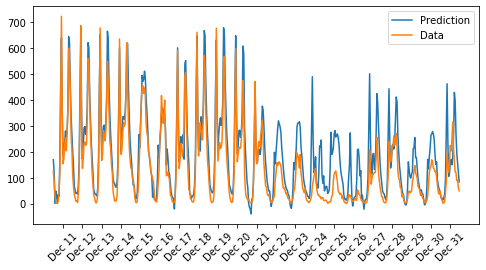

In [114]:
fig, ax = plt.subplots(figsize=(8,4))

#由于我们对 使用量'cnt' 进行了标准化，现在我们反向还原数据
mean, std = scaled_features['cnt']
predictions = network.run(test_features).T*std + mean

ax.plot(predictions[0], label='Prediction')
ax.plot((test_targets['cnt']*std + mean).values, label='Data')
ax.legend()

dates = pd.to_datetime(rides.iloc[test_data.index]['dteday'])
dates = dates.apply(lambda d: d.strftime('%b %d'))
ax.set_xticks(np.arange(len(dates))[12::24])
ax.set_xticklabels(dates[12::24], rotation=45);

可以看到，在dec21之前模型拟合得很好，但是在dec21之后模型不能很好地预测了，这是因为共享单车业务量出现了异常下降导致的,如下图所示

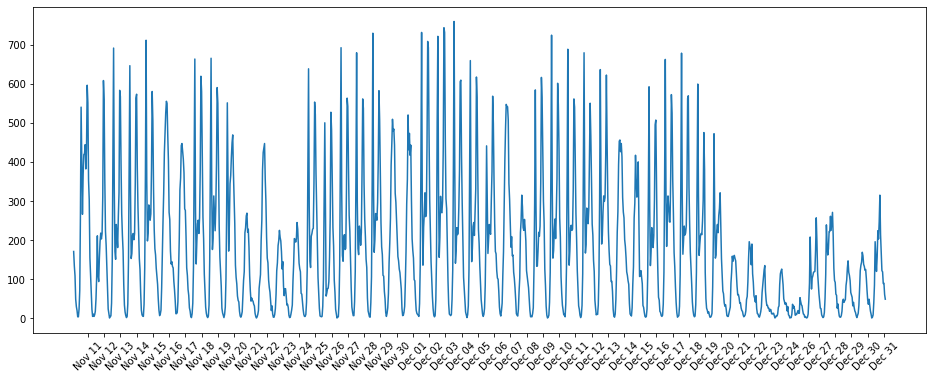

In [123]:
fig,ax  = plt.subplots(figsize = (16,6))
ax.plot(rides[-24*50:]['cnt'])

dates = pd.to_datetime(rides['dteday'])
dates = dates.apply(lambda d: d.strftime('%b %d'))
ax.set_xticks(np.arange(16200,17400)[0::24])
ax.set_xticklabels(dates[-50*24::24], rotation=45);